In [1]:
import os
from collections import OrderedDict

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from scipy import io as sio
import sklearn.metrics as sm
from sklearn.svm import LinearSVC

from keras.utils import np_utils

# TCN imports 
import tf_models, datasets, utils, metrics
from utils import imshow_

# ---------- Directories & User inputs --------------
# Location of data/features folder
base_dir = os.path.expanduser("../")

save_predictions = [False, True][1]
viz_predictions = [False, True][1]
viz_weights = [False, True][0]

# Set dataset and action label granularity (if applicable)
dataset = ["50Salads", "JIGSAWS", "MERL", "GTEA"][0]
granularity = ["eval", "mid"][1]
sensor_type = ["video", "sensors"][0]

# Set model and parameters
model_type = ["SVM", "LSTM", "LC-SC-CRF", "tCNN",  "DilatedTCN", "ED-TCN", "AP-TCN", "TDNN"][5]
# causal or acausal? (If acausal use Bidirectional LSTM)
causal = [False, True][0]

# How many latent states/nodes per layer of network
# Only applicable to the TCNs. The ECCV and LSTM  model suses the first element from this list.
n_nodes = [64, 96]
nb_epoch = 50 #200
video_rate = 3
conv = {'50Salads':25, "JIGSAWS":20, "MERL":5, "GTEA":25}[dataset]

# Which features for the given dataset
features = "SpatialCNN"
bg_class = 0 if dataset is not "JIGSAWS" else None

if dataset == "50Salads":
    features = "SpatialCNN_" + granularity

data = datasets.Dataset(dataset, base_dir)
trial_metrics = metrics.ComputeMetrics(overlap=.1, bg_class=bg_class)

device_type = "/gpu:1"

Using TensorFlow backend.


(n_classes:18)
(# Feat:128)
test ED-TCN
before fit
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 552, 128)      0                                            
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)  (None, 552, 64)       204864      input_1[0][0]                    
____________________________________________________________________________________________________
spatialdropout1d_1 (SpatialDropo (None, 552, 64)       0           convolution1d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 552, 64)       0           spatialdropout1d_1[0][0]         
________________________________________

metrics.py:234: RuntimeWarning: invalid value encountered in double_scalars
  F1 = 2 * (precision*recall) / (precision+recall)


Trial Split_1: accuracy:67.37, edit_score:69.13, overlap_f1:1.129
()
(n_classes:18)
(# Feat:128)
test ED-TCN
before fit
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 552, 128)      0                                            
____________________________________________________________________________________________________
convolution1d_5 (Convolution1D)  (None, 552, 64)       204864      input_2[0][0]                    
____________________________________________________________________________________________________
spatialdropout1d_5 (SpatialDropo (None, 552, 64)       0           convolution1d_5[0][0]            
____________________________________________________________________________________________________
activation_5 (Activation)        (None, 552, 64)       0           spati

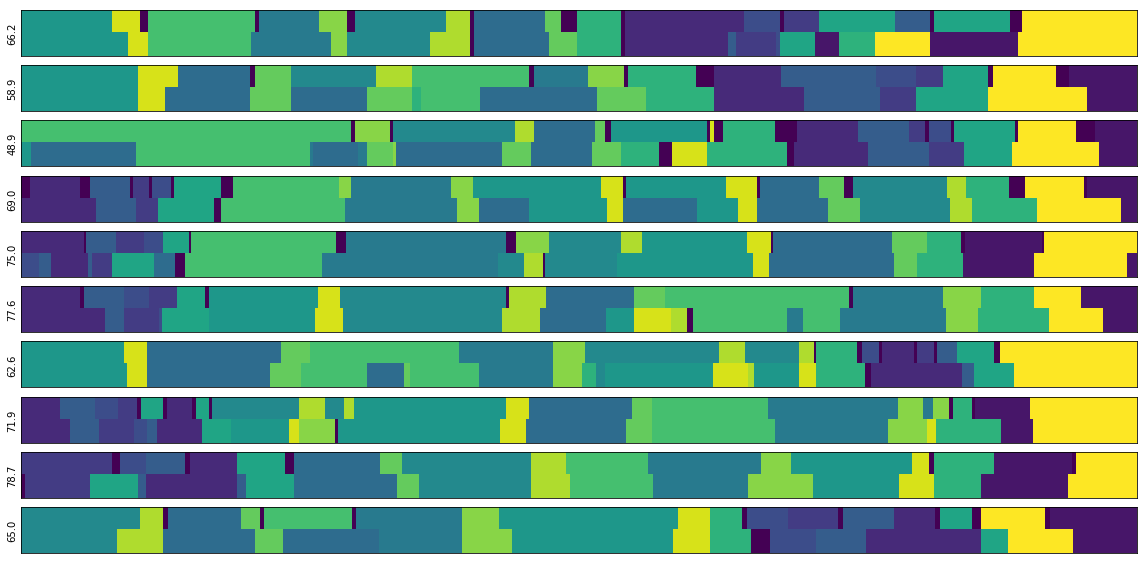

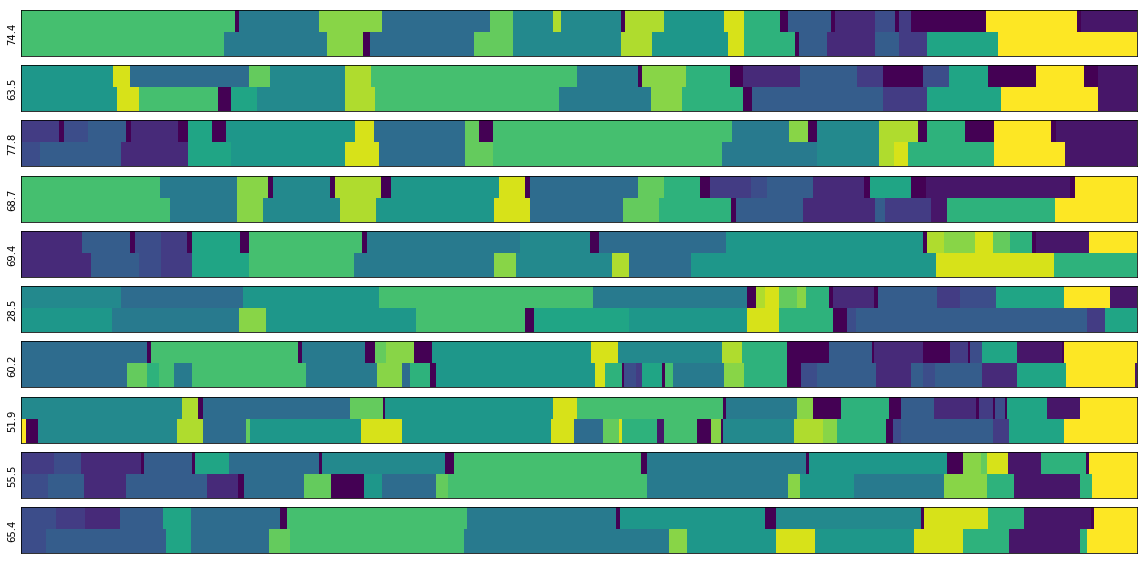

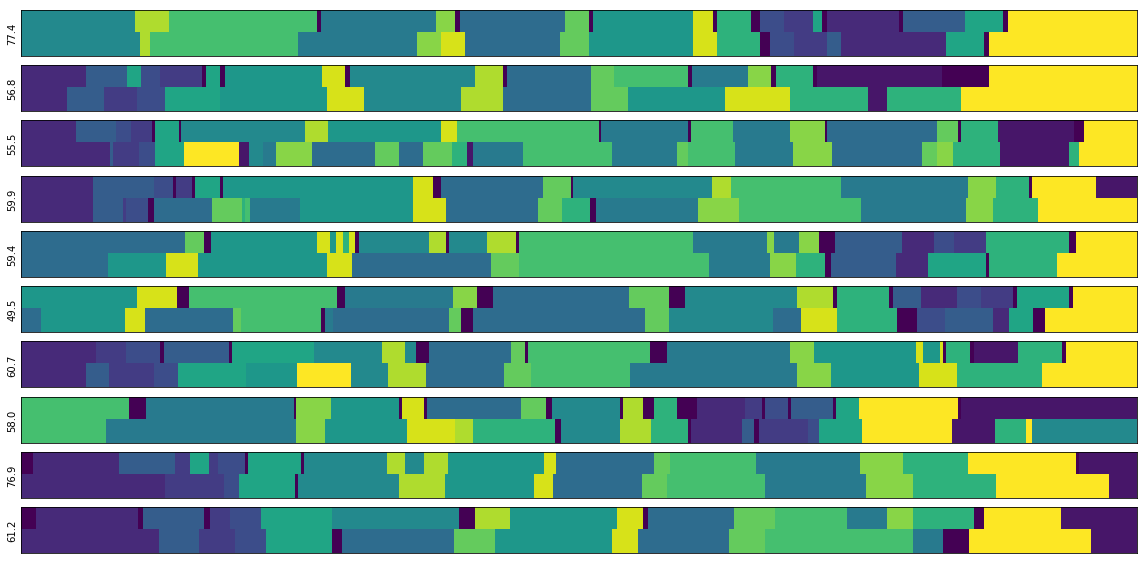

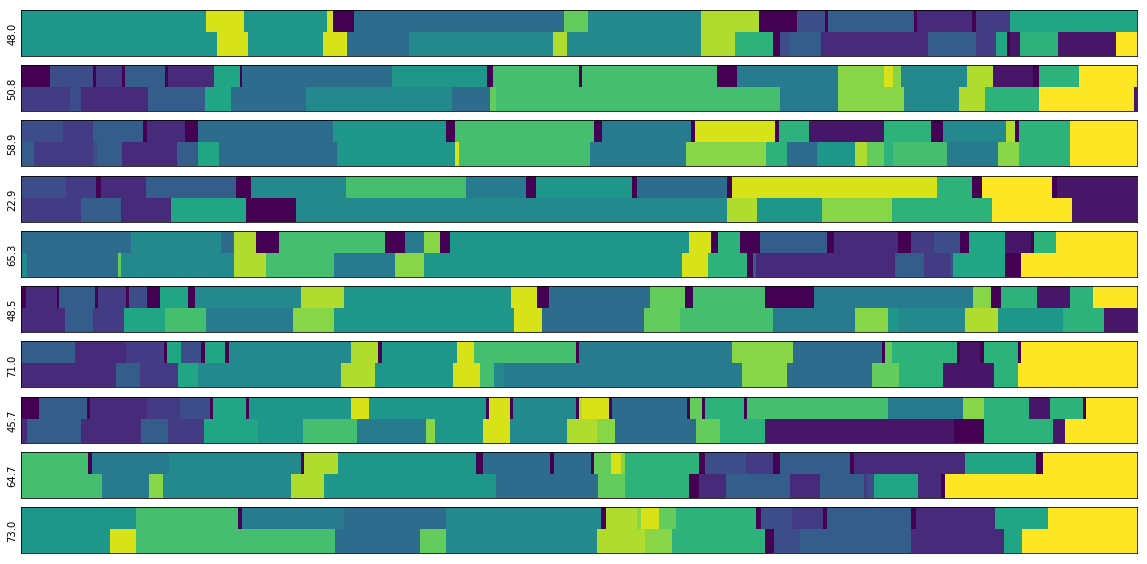

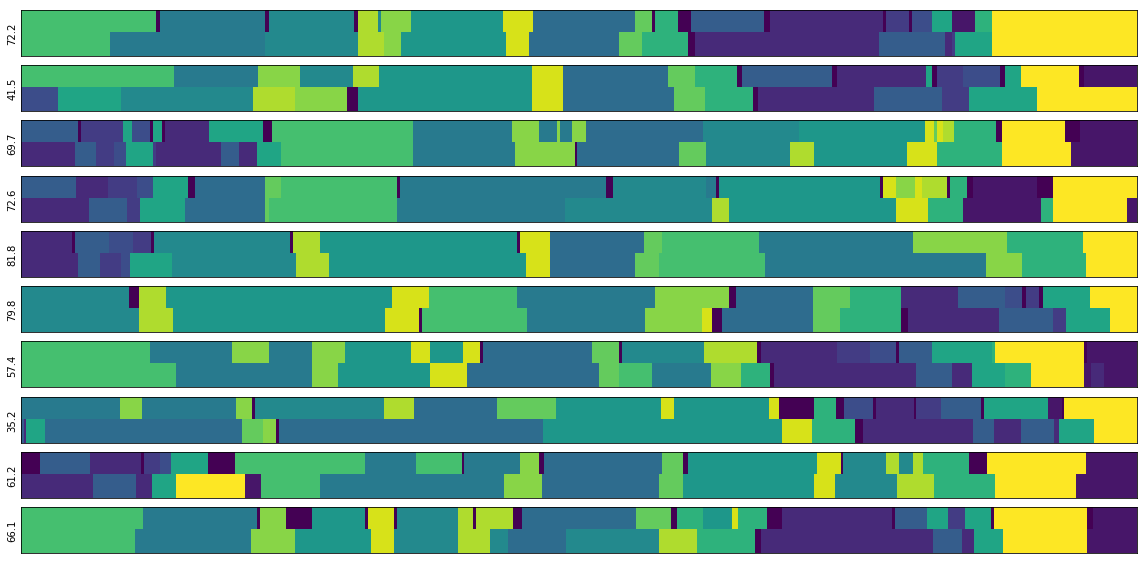

In [2]:
#from IPython.core.debugger import Pdb # for debugging, jinchoi@vt.edu
#pdb = Pdb()

# ------------------------------------------------------------------
# Evaluate using different filter lengths
if 1:
# for conv in [5, 10, 15, 20]:
    # Initialize dataset loader & metrics
    data = datasets.Dataset(dataset, base_dir)
    trial_metrics = metrics.ComputeMetrics(overlap=.1, bg_class=bg_class)

    # Load data for each split
    for split in data.splits:
        if sensor_type=="video":
            feature_type = "A" if model_type != "SVM" else "X"
        else:
            feature_type = "S"

        X_train, y_train, X_test, y_test = data.load_split(features, split=split, 
                                                            sample_rate=video_rate, 
                                                            feature_type=feature_type)

        if trial_metrics.n_classes is None:
            trial_metrics.set_classes(data.n_classes)

        n_classes = data.n_classes
        print '(n_classes:{0})'.format(n_classes)
        train_lengths = [x.shape[0] for x in X_train]
        test_lengths = [x.shape[0] for x in X_test]
        n_train = len(X_train)
        n_test = len(X_test)

        n_feat = data.n_features
        print '(# Feat:{0})'.format(n_feat)

        # ------------------ Models ----------------------------
        if model_type == "SVM":
            svm = LinearSVC()
            svm.fit(np.vstack(X_train), np.hstack(y_train))
            P_test = [svm.predict(x) for x in X_test]

            # AP_x contains the per-frame probabilities (or class) for each class
            AP_train = [svm.decision_function(x) for x in X_train]
            AP_test = [svm.decision_function(x) for x in X_test]
            param_str = "SVM"

        # --------- CVPR model ----------
        elif model_type in ["tCNN", "ED-TCN", "DilatedTCN", "TDNN", "LSTM", "AP-TCN"]:
            # Go from y_t = {from 1 to C} to one-hot vector (e.g. y_t = [0, 0, 1, 0])
            Y_train = [np_utils.to_categorical(y, n_classes) for y in y_train]
            Y_test = [np_utils.to_categorical(y, n_classes) for y in y_test]

            # In order process batches simultaneously all data needs to be of the same length
            # So make all same length and mask out the ends of each.
            n_layers = len(n_nodes)
            max_len = max(np.max(train_lengths), np.max(test_lengths))
            max_len = int(np.ceil(max_len / (2**n_layers)))*2**n_layers

            X_train_m, Y_train_, M_train = utils.mask_data(X_train, Y_train, max_len, mask_value=-1)
            X_test_m, Y_test_, M_test = utils.mask_data(X_test, Y_test, max_len, mask_value=-1)

            if model_type == "tCNN":
                model, param_str = tf_models.temporal_convs_linear(n_nodes[0], conv, n_classes, n_feat, 
                                                    max_len, causal=causal, return_param_str=True)
            elif model_type == "ED-TCN":
                model, param_str = tf_models.ED_TCN(n_nodes, conv, n_classes, n_feat, max_len, causal=causal, activation='norm_relu', return_param_str=True) 
                #model, param_str = tf_models.ED_TCN_atrous(n_nodes, conv, n_classes, n_feat, max_len, causal=causal, activation='norm_relu', return_param_str=True)                 
            elif model_type == "AP-TCN":
                model, param_str = tf_models.AP_TCN(n_nodes, conv, n_classes, n_feat, max_len, causal=causal, 
                                        activation='norm_relu', return_param_str=True)               
            elif model_type == "TDNN":
                model, param_str = tf_models.TimeDelayNeuralNetwork(n_nodes, conv, n_classes, n_feat, max_len, 
                                   causal=causal, activation='tanh', return_param_str=True)
            elif model_type == "DilatedTCN":
                model, param_str = tf_models.Dilated_TCN(n_feat, n_classes, n_nodes[0], L, B, max_len=max_len, 
                                        causal=causal, return_param_str=True)
            elif model_type == "LSTM":
                model, param_str = tf_models.BidirLSTM(n_nodes[0], n_classes, n_feat, causal=causal, return_param_str=True)

            print("before fit")
            model.summary()
            #pdb.set_trace()
            model.fit(X_train_m, Y_train_, nb_epoch=nb_epoch, batch_size=8, verbose=1, sample_weight=M_train[:,:,0]) 
            print("after fit")
            
            print("1")
            AP_train = model.predict(X_train_m, verbose=0)
            print("2")
            AP_test = model.predict(X_test_m, verbose=0)
            print("3")
            AP_train = utils.unmask(AP_train, M_train)
            print("4")
            AP_test = utils.unmask(AP_test, M_test)
            print("5")
            
            P_train = [p.argmax(1) for p in AP_train]
            P_test = [p.argmax(1) for p in AP_test]
            
        # --------- ICRA model ----------
        elif model_type == 'LC-SC-CRF':
            try:
                from LCTM import models
            except:
                print("Error: LCTM not installed")
                print("For more info: https://github.com/colincsl/LCTM")
                break
            X_train_T = [x.T for x in X_train]
            X_test_T = [x.T for x in X_test]
            n_latent_per_class = 4 
            skip = conv
            model = models.LatentConvModel(n_latent=n_latent_per_class, conv_len=conv, skip=skip, prior=True, debug=True)
            model.fit(X_train_T, y_train, n_iter=200, learning_rate=.1, pretrain=True, verbose=True)
            model.filter_len = conv//2+1 if conv>1 else 1
            P_test = model.predict(X_test_T, inference="filtered")
            AP_train = [x.T for x in model.decision_function(X_train_T)]
            AP_test = [x.T for x in model.decision_function(X_test_T)]

            param_str = "LC-SC-CRF_C{}_S{}_I{}".format(conv, skip, model.inference_type)

        # --------- DTW baseline model ----------
        elif model_type == "DTW":
            try:
                import DTW
            except:
                print("Error: DTW not installed")
                print("For more info: https://github.com/colincsl/LCTM")
                break        

            P_test = []
            for i in range(n_test):
                dists, preds = [], []
                for j in range(n_train):
                    dist, c = DTW(X_train[j], X_test[i], output_correspondences=True)
                    dists += [dist]
                    preds += [y_train[j][c]]
                idx_best = np.argmin(dists)
                P_test += [preds[idx_best]]

        else:
            print("Model not available:", model_type)

        param_str = "_".join([granularity, sensor_type, param_str])
        print(param_str)

        # --------- Metrics ----------    
        trial_metrics.add_predictions(split, P_test, y_test)       
        trial_metrics.print_trials()
        print()

        # ----- Save predictions -----
        if save_predictions:
            dir_out = os.path.expanduser(base_dir+"/predictions/{}/{}/".format(dataset,param_str))

            # Make sure folder exists
            if not os.path.isdir(dir_out):
                os.makedirs(dir_out)

            out = {"P":P_test, "Y":y_test, "S":AP_test}
            sio.savemat( dir_out+"/{}.mat".format(split), out)      

        # ---- Viz predictions -----
        if viz_predictions:
            max_classes = data.n_classes - 1
            # # Output all truth/prediction pairs
            plt.figure(split, figsize=(20,10))
            P_test_ = np.array(P_test)/float(n_classes-1)
            y_test_ = np.array(y_test)/float(n_classes-1)
            for i in range(len(y_test)):
                P_tmp = np.vstack([y_test_[i], P_test_[i]])
                plt.subplot(n_test,1,i+1); imshow_(P_tmp, vmin=0, vmax=1)
                plt.xticks([])
                plt.yticks([])
                acc = np.mean(y_test[i]==P_test[i])*100
                plt.ylabel("{:.01f}".format(acc))
                # plt.title("Acc: {:.03}%".format(100*np.mean(P_test[i]==y_test[i])))

        # ---- Viz weights -----
        if viz_weights and model_type is "TCN":
            # Output weights at the first layer
            plt.figure(2, figsize=(15,15))
            ws = model.get_weights()[0]
            for i in range(min(36, len(ws.T))):
                plt.subplot(6,6,i+1)
                # imshow_(model.get_weights()[0][i][:,:,0]+model.get_weights()[1][i])
                imshow_(np.squeeze(ws[:,:,:,i]).T)
                # Output weights at the first layer

            for l in range(2*n_layers):
                plt.figure(l+1, figsize=(15,15))
                ws = model.get_weights()[l*2]
                for i in range(min(36, len(ws.T))):
                    plt.subplot(6,6,i+1)
                    # imshow_(model.get_weights()[0][i][:,:,0]+model.get_weights()[1][i])
                    imshow_(np.squeeze(ws[:,:,:,i]).T)
                    # Output weights at the first layer

    print()
    trial_metrics.print_scores()
    trial_metrics.print_trials()
    print()

In [88]:
from itertools import groupby

# a function for trimming video features
def split_actions(seq):
    start = 0
    duration = 0
    action_labels = list()    
    for k,g in groupby(seq):
        this_group = list(g)
        label = k
        start += duration
        duration = len(this_group)
        end = start + duration - 1
        print 'label:{0}, start:{1}, duration:{2}'.format(label, start, duration)
        action_labels.append((label,start,end,duration))
    return action_labels

In [92]:
for i in range(len(y_train)):
    print 'data {0}'.format(i+1)
    labels = split_actions(y_train[0])

data 1
label:9, start:0, duration:54
label:16, start:54, duration:11
label:9, start:65, duration:24
label:16, start:89, duration:2
label:0, start:91, duration:6
label:6, start:97, duration:61
label:13, start:158, duration:7
label:8, start:165, duration:33
label:15, start:198, duration:17
label:0, start:215, duration:11
label:4, start:226, duration:8
label:0, start:234, duration:1
label:5, start:235, duration:25
label:0, start:260, duration:1
label:2, start:261, duration:16
label:0, start:277, duration:1
label:3, start:278, duration:10
label:10, start:288, duration:37
data 2
label:9, start:0, duration:54
label:16, start:54, duration:11
label:9, start:65, duration:24
label:16, start:89, duration:2
label:0, start:91, duration:6
label:6, start:97, duration:61
label:13, start:158, duration:7
label:8, start:165, duration:33
label:15, start:198, duration:17
label:0, start:215, duration:11
label:4, start:226, duration:8
label:0, start:234, duration:1
label:5, start:235, duration:25
label:0, st

(40, 552)

In [114]:
X_train_m.shape

(40, 552, 128)

In [5]:
Y_train_.shape

(40, 552, 18)

In [6]:
M_train[:,:,0].shape

(40, 552)

In [3]:
M_train.shape

(40, 552, 1)

In [10]:
M_train.shape

(40, 552, 1)

In [7]:
len(P_test)

10

In [8]:
len(P_test[0])

338

In [9]:
len(y_test)

10

In [4]:
len(P_test)

10

In [3]:
len(y_test[0])

338

In [3]:
P_test

[array([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3, 10, 10, 10, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 16, 16, 16, 16, 16, 16,
        16, 16,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6, 13, 13, 13, 13,
        13, 13, 13, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
         0,  0,  0,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2, 

In [3]:
y_test

[array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12,  0,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  0,
        15, 15, 15, 15, 15, 15,  8, 14, 14, 14, 14, 14, 14, 14, 14, 14,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 16, 16, 16, 16, 16, 16, 16,
        16, 16,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6, 13,
        13, 13, 13, 13,  0, 11, 11, 11, 11, 11, 11, 11,  0,  0,  0,  0,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5, 

In [8]:
len(AP_train)

40

In [10]:
len(AP_train[0][0])

18

In [11]:
AP_train[0]

array([[  9.14814323e-03,   1.67114742e-03,   1.03872124e-04, ...,
          1.47746340e-03,   2.23441003e-03,   8.64349247e-04],
       [  4.93288320e-03,   1.16009859e-03,   6.41056904e-05, ...,
          8.70885793e-04,   1.28356589e-03,   5.94841142e-04],
       [  2.93883937e-03,   8.47498828e-04,   4.06198487e-05, ...,
          5.31762664e-04,   8.42455949e-04,   4.46405844e-04],
       ..., 
       [  4.05382775e-02,   1.02093071e-02,   3.26932059e-03, ...,
          6.54811331e-04,   1.04146055e-03,   9.84054804e-03],
       [  5.88496663e-02,   1.61717813e-02,   3.56821856e-03, ...,
          7.59095186e-04,   1.42300071e-03,   1.75006855e-02],
       [  9.15936008e-02,   2.74008047e-02,   4.14178381e-03, ...,
          9.77827818e-04,   2.21864926e-03,   3.95721756e-02]], dtype=float32)